# Pocket RMSD

This notebook explores the effect of the pocket RMSD between the reference structure and the structure used during corss-docking on the **Fred** docking performance. **Hybrid** and **Posit** are excluded, since their performance is highly dependent on the co-crystallized ligand.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
docking_benchmark_dataset = pd.read_csv("../data/docking_benchmark_dataset.csv", index_col=0)
pocket_rmsd_matrix = pd.read_csv("../data/pocket_rmsd_matrix.csv", index_col=0)

In [5]:
def get_pocket_rmsd(pdb_id1, pdb_id2, docking_benchmark_dataset=docking_benchmark_dataset, pocket_rmsd_matrix=pocket_rmsd_matrix):
    """Retrieve the KLIFS pocket RMSD from two kinase structures."""
    structure_klifs_id1 = docking_benchmark_dataset[
        docking_benchmark_dataset["structure.pdb_id"] == pdb_id1
    ]["structure.klifs_id"].iloc[0]
    structure_klifs_id2 = docking_benchmark_dataset[
        docking_benchmark_dataset["structure.pdb_id"] == pdb_id2
    ]["structure.klifs_id"].iloc[0] 
    pocket_rmsd = pocket_rmsd_matrix[str(structure_klifs_id1)][structure_klifs_id2]
    return pocket_rmsd

In [6]:
fred_results["pocket_rmsd"] = fred_results.apply(lambda row: get_pocket_rmsd(row["protein_pdb_id"], row["ligand_pdb_id"]), axis=1)

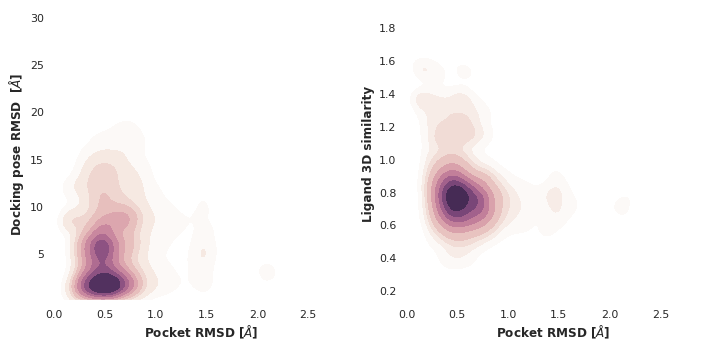

In [7]:
def plot_pocket_rmsd(fred_results, directory=OUT_DIR):
    
    # select pose 1 for Fred, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]
    
    # 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # plot pocket similarity vs RMSD
    cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)
    sns.kdeplot(x=fred_results["pocket_rmsd"], y=fred_results["rmsd"], cmap=cmap, fill=True, cut=0.1, thresh=1/10, levels=10, ax=axes[0])
    axes[0].set_xlabel("Pocket RMSD [$\AA$]", fontweight="bold")
    axes[0].set_ylabel("Docking pose RMSD  [$\AA$]", fontweight="bold")
    axes[0].set_facecolor((1,1,1))
    
    # plot pocket similarity vs 3D similarity
    cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)
    sns.kdeplot(x=fred_results["pocket_rmsd"], y=fred_results["shape_similarity"], cmap=cmap, fill=True, cut=0.1, thresh=1/10, levels=10, ax=axes[1])
    axes[1].set_xlabel("Pocket RMSD [$\AA$]", fontweight="bold")
    axes[1].set_ylabel("Ligand 3D similarity", fontweight="bold")
    axes[1].set_facecolor((1,1,1))
    
    plt.tight_layout()
    plt.savefig(directory / "fred_pocket_rmsd.png", dpi=300)

plot_pocket_rmsd(fred_results)